# Module 03: Word Embeddings

**From Sparse to Dense: Distributed Representations of Words**

---

## 1. Objectives

- ✅ Understand the distributional hypothesis
- ✅ Master Word2Vec (CBOW & Skip-gram) with negative sampling
- ✅ Implement Skip-gram from scratch
- ✅ Explore GloVe and FastText
- ✅ Visualize and analyze word embeddings

## 2. Prerequisites

- [Module 02: Text Representation](../02_text_representation/02_text_representation.ipynb)

## 3. Intuition & Motivation

### The Problem with One-Hot Encoding

```
cat  = [1, 0, 0, 0, 0, ...]
dog  = [0, 1, 0, 0, 0, ...]
king = [0, 0, 1, 0, 0, ...]
```

**Problems:**
- No similarity: `cos(cat, dog) = 0`
- Huge dimensions: vocab size = 50,000+
- No meaning captured

### The Distributional Hypothesis

> **"Words with similar contexts have similar meanings"**  
> — J.R. Firth (1957)

```
"The cat sat on the mat"
"The dog sat on the rug"
→ 'cat' and 'dog' are similar (same context)
```

### Word Embeddings: Dense Vectors

```
cat  = [0.2, -0.4, 0.7, 0.1, ...] (300 dims)
dog  = [0.3, -0.3, 0.6, 0.2, ...]
king = [0.8, 0.5, -0.2, 0.9, ...]
```

Now: `cos(cat, dog) ≈ 0.8` (similar!)

In [8]:
# Setup
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter
from typing import List, Tuple
import random

# For visualization
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

print("Setup complete!")

Setup complete!


## 4. Mathematical Foundation

### 4.1 Word2Vec: Two Architectures

| Model | Input | Output | Learns |
|-------|-------|--------|--------|
| **CBOW** | Context words | Center word | "What word fits here?" |
| **Skip-gram** | Center word | Context words | "What's around this word?" |

### 4.2 Skip-gram Objective

Given center word $w_c$, maximize probability of context words:

$$\max \sum_{t=1}^{T} \sum_{-m \leq j \leq m, j \neq 0} \log P(w_{t+j} | w_t)$$

Where:
$$P(w_o | w_c) = \frac{\exp(u_o^\top v_c)}{\sum_{w \in V} \exp(u_w^\top v_c)}$$

- $v_c$ = embedding of center word
- $u_o$ = output embedding of context word

### 4.3 Negative Sampling

Computing softmax over 50K words is expensive!

**Solution**: Instead of predicting the right word, distinguish real pairs from fake pairs:

$$\log \sigma(u_o^\top v_c) + \sum_{k=1}^{K} \mathbb{E}_{w_k \sim P_n(w)} [\log \sigma(-u_{w_k}^\top v_c)]$$

- Sample $K$ negative words (typically 5-20)
- Train to distinguish real context from random

## 5. Skip-gram with Negative Sampling from Scratch

In [9]:
class SkipGram:
    """Skip-gram with Negative Sampling from scratch."""

    def __init__(self, vocab_size: int, embedding_dim: int = 100, neg_samples: int = 5):
        self.embedding_dim = embedding_dim
        self.neg_samples = neg_samples
        self.vocab_size = vocab_size

        # Two embedding matrices: input (center) and output (context)
        # Initialize with small random values
        self.W_in = np.random.randn(vocab_size, embedding_dim) * 0.01
        self.W_out = np.random.randn(vocab_size, embedding_dim) * 0.01

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

    def train_pair(self, center_idx: int, context_idx: int, neg_indices: List[int], lr: float = 0.01):
        """Train on one (center, context) pair with negative samples."""

        # Get embeddings
        v_c = self.W_in[center_idx]  # Center word embedding
        u_o = self.W_out[context_idx]  # Context word embedding

        # Positive sample: should be 1
        score_pos = np.dot(u_o, v_c)
        sig_pos = self.sigmoid(score_pos)

        # Gradient for positive sample
        grad_pos = (sig_pos - 1) * v_c
        grad_center = (sig_pos - 1) * u_o

        # Negative samples: should be 0
        for neg_idx in neg_indices:
            u_neg = self.W_out[neg_idx]
            score_neg = np.dot(u_neg, v_c)
            sig_neg = self.sigmoid(score_neg)

            # Gradient for negative sample
            self.W_out[neg_idx] -= lr * sig_neg * v_c
            grad_center += sig_neg * u_neg

        # Update embeddings
        self.W_out[context_idx] -= lr * grad_pos
        self.W_in[center_idx] -= lr * grad_center

    def get_embedding(self, word_idx: int) -> np.ndarray:
        """Get word embedding (use input matrix)."""
        return self.W_in[word_idx]

    def similarity(self, idx1: int, idx2: int) -> float:
        """Cosine similarity between two words."""
        v1 = self.W_in[idx1]
        v2 = self.W_in[idx2]
        return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [10]:
# Training example
corpus = [
    "the cat sat on the mat",
    "the dog ran in the park",
    "cats and dogs are pets",
    "the cat chased the dog",
    "dogs bark and cats meow"
]

# Build vocabulary
words = ' '.join(corpus).lower().split()
word_counts = Counter(words)
vocab = {word: idx for idx, word in enumerate(word_counts.keys())}
idx_to_word = {idx: word for word, idx in vocab.items()}
vocab_size = len(vocab)

print(f"Vocabulary size: {vocab_size}")
print(f"Vocabulary: {list(vocab.keys())}")

# Generate training pairs (center, context)
def generate_pairs(corpus, vocab, window_size=2):
    pairs = []
    for sentence in corpus:
        words = sentence.lower().split()
        indices = [vocab[w] for w in words]
        for i, center in enumerate(indices):
            for j in range(max(0, i-window_size), min(len(indices), i+window_size+1)):
                if i != j:
                    pairs.append((center, indices[j]))
    return pairs

pairs = generate_pairs(corpus, vocab)
print(f"Training pairs: {len(pairs)}")
print(f"Sample pairs: {[(idx_to_word[c], idx_to_word[ctx]) for c, ctx in pairs[:5]]}")

Vocabulary size: 17
Vocabulary: ['the', 'cat', 'sat', 'on', 'mat', 'dog', 'ran', 'in', 'park', 'cats', 'and', 'dogs', 'are', 'pets', 'chased', 'bark', 'meow']
Training pairs: 78
Sample pairs: [('the', 'cat'), ('the', 'sat'), ('cat', 'the'), ('cat', 'sat'), ('cat', 'on')]


In [11]:
# Train Skip-gram
model = SkipGram(vocab_size, embedding_dim=50, neg_samples=5)

epochs = 100
for epoch in range(epochs):
    random.shuffle(pairs)
    for center, context in pairs:
        # Sample negative words
        neg_indices = random.sample([i for i in range(vocab_size) if i != context], model.neg_samples)
        model.train_pair(center, context, neg_indices, lr=0.05)

    if (epoch + 1) % 20 == 0:
        sim = model.similarity(vocab['cat'], vocab['dog'])
        print(f"Epoch {epoch+1}: cat-dog similarity = {sim:.3f}")

# Test similarities
print("\nSimilarities:")
for w1, w2 in [('cat', 'dog'), ('cat', 'the'), ('dogs', 'cats')]:
    if w1 in vocab and w2 in vocab:
        print(f"  {w1} - {w2}: {model.similarity(vocab[w1], vocab[w2]):.3f}")

Epoch 20: cat-dog similarity = 0.990
Epoch 40: cat-dog similarity = 0.900
Epoch 60: cat-dog similarity = 0.726
Epoch 80: cat-dog similarity = 0.730
Epoch 100: cat-dog similarity = 0.705

Similarities:
  cat - dog: 0.705
  cat - the: 0.431
  dogs - cats: 0.499


## 6. PyTorch Implementation

In [12]:
class SkipGramPyTorch(nn.Module):
    """Skip-gram with PyTorch."""

    def __init__(self, vocab_size: int, embedding_dim: int):
        super().__init__()
        self.center_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # Initialize
        nn.init.xavier_uniform_(self.center_embeddings.weight)
        nn.init.xavier_uniform_(self.context_embeddings.weight)

    def forward(self, center, context, neg_context):
        """
        center: (batch,)
        context: (batch,)
        neg_context: (batch, num_neg)
        """
        # Get embeddings
        center_emb = self.center_embeddings(center)  # (batch, dim)
        context_emb = self.context_embeddings(context)  # (batch, dim)
        neg_emb = self.context_embeddings(neg_context)  # (batch, num_neg, dim)

        # Positive score
        pos_score = torch.sum(center_emb * context_emb, dim=1)  # (batch,)
        pos_loss = -torch.log(torch.sigmoid(pos_score) + 1e-10)

        # Negative scores
        neg_score = torch.bmm(neg_emb, center_emb.unsqueeze(2)).squeeze(2)  # (batch, num_neg)
        neg_loss = -torch.sum(torch.log(torch.sigmoid(-neg_score) + 1e-10), dim=1)

        return (pos_loss + neg_loss).mean()

    def get_embedding(self, word_idx):
        return self.center_embeddings.weight[word_idx].detach().numpy()

# Quick test
model_pt = SkipGramPyTorch(vocab_size, 50)
print(f"PyTorch model parameters: {sum(p.numel() for p in model_pt.parameters())}")

PyTorch model parameters: 1700


## 7. Using Pretrained Embeddings (gensim)

In [13]:
!pip install gensim -q

# Using gensim Word2Vec
from gensim.models import Word2Vec

# Prepare sentences
sentences = [s.lower().split() for s in corpus]

# Train Word2Vec
w2v = Word2Vec(
    sentences,
    vector_size=100,
    window=2,
    min_count=1,
    sg=1,  # Skip-gram
    epochs=100
)

print("Gensim Word2Vec trained!")
print(f"\nMost similar to 'cat':")
for word, score in w2v.wv.most_similar('cat', topn=3):
    print(f"  {word}: {score:.3f}")

Gensim Word2Vec trained!

Most similar to 'cat':
  park: 0.172
  dog: 0.148
  cats: 0.138


## 8. GloVe & FastText

### GloVe (Global Vectors)

- Uses **co-occurrence matrix** instead of sliding window
- Objective: $w_i^\top w_j + b_i + b_j = \log(X_{ij})$
- Combines count-based and prediction-based

### FastText

- Represents words as **sum of character n-grams**
- "where" = `<wh, whe, her, ere, re>`
- **Handles OOV words** (major advantage!)
- Better for morphologically rich languages

In [14]:
# FastText with gensim
from gensim.models import FastText

ft = FastText(
    sentences,
    vector_size=100,
    window=2,
    min_count=1,
    epochs=100
)

# FastText can handle OOV!
print("FastText handles OOV words:")
print(f"  'catlike' (OOV) embedding shape: {ft.wv['catlike'].shape}")
print(f"  'doggy' (OOV) embedding shape: {ft.wv['doggy'].shape}")

FastText handles OOV words:
  'catlike' (OOV) embedding shape: (100,)
  'doggy' (OOV) embedding shape: (100,)


## 9. Visualization

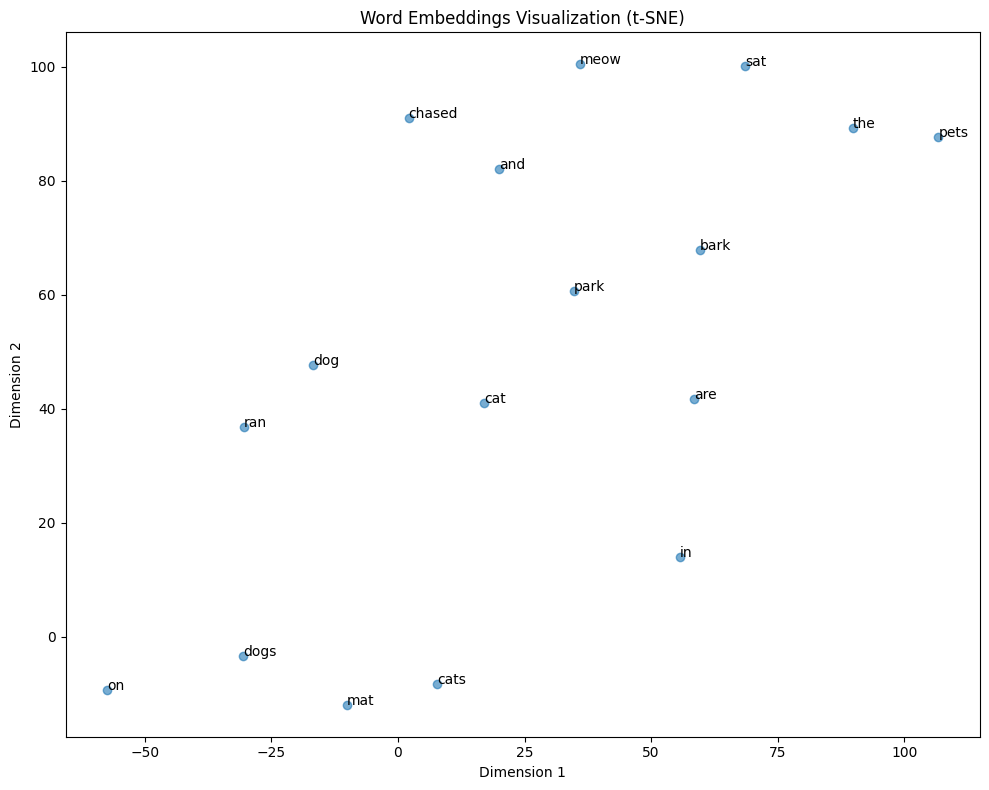

In [15]:
# Visualize embeddings with t-SNE
words_to_plot = list(vocab.keys())
embeddings = np.array([w2v.wv[w] for w in words_to_plot])

# t-SNE reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, len(words_to_plot)-1))
embeddings_2d = tsne.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6)
for i, word in enumerate(words_to_plot):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=10)
plt.title('Word Embeddings Visualization (t-SNE)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.tight_layout()
plt.show()

## 10. 🔥 Real-World Usage

### In 2024

Static embeddings (Word2Vec, GloVe) are **mostly replaced** by contextual embeddings (BERT).

**Still useful for:**
- Quick prototyping
- Understanding embedding concepts
- Limited compute environments
- Initialization for other models

### Pretrained Sources

| Source | Size | Languages |
|--------|------|----------|
| GloVe (Stanford) | 6B, 840B tokens | English |
| FastText (Facebook) | 157 languages | Multilingual |
| Word2Vec (Google News) | 3M words | English |

### Key Rule
> **Always use pretrained embeddings. Never train from scratch.**
> (Unless you have a very specific domain)

## 11. Interview Questions

**Q1: What's the difference between CBOW and Skip-gram?**
<details><summary>Answer</summary>

- **CBOW**: Predicts center word from context (faster, better for frequent words)
- **Skip-gram**: Predicts context from center word (better for rare words)
</details>

**Q2: How does negative sampling work?**
<details><summary>Answer</summary>

Instead of softmax over vocab, train binary classifier to distinguish real (center, context) pairs from random pairs. Sample K negative examples proportional to word frequency.
</details>

**Q3: What are limitations of Word2Vec?**
<details><summary>Answer</summary>

- Single vector per word (no polysemy: "bank" = river bank or money bank)
- OOV words not handled
- Static (no context)
</details>

**Q4: Why is FastText better for OOV?**
<details><summary>Answer</summary>

FastText represents words as sum of character n-grams. Even unseen words share n-grams with training words.
</details>

## 12. Summary

- **Distributional Hypothesis**: Similar context → similar meaning
- **Word2Vec**: CBOW (context→word) or Skip-gram (word→context)
- **Negative Sampling**: Efficient training via binary classification
- **GloVe**: Co-occurrence matrix approach
- **FastText**: Character n-grams, handles OOV
- **2024**: Use pretrained, prefer contextual (BERT) when possible

## 13. Exercises

1. Implement CBOW from scratch
2. Load pretrained GloVe and find word analogies (king - man + woman = ?)
3. Compare Word2Vec vs FastText on domain-specific text
4. Analyze bias in embeddings (gender associations)

## 14. References

- [Word2Vec Paper](https://arxiv.org/abs/1301.3781)
- [GloVe Paper](https://nlp.stanford.edu/pubs/glove.pdf)
- [FastText Paper](https://arxiv.org/abs/1607.04606)
- [Illustrated Word2Vec](https://jalammar.github.io/illustrated-word2vec/)

---
**Next:** [Module 04: PyTorch Embedding Layers](../04_pytorch_embeddings/04_pytorch_embeddings.ipynb)